## Inspiration
1. https://www.researchgate.net/profile/Ali-Javed/publication/266411344_An_Efficient_Brain_Tumor_Detection_Algorithm_Using_Watershed_Thresholding_Based_Segmentation/links/54e0c9460cf2953c22b744be/An-Efficient-Brain-Tumor-Detection-Algorithm-Using-Watershed-Thresholding-Based-Segmentation.pdf?origin=publication_detail
2. https://svi.nl/watershed#:~:text=The%20watershed%20method%20has%20the,this%20will%20influence%20the%20segmentation


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

(-0.5, 224.5, 224.5, -0.5)

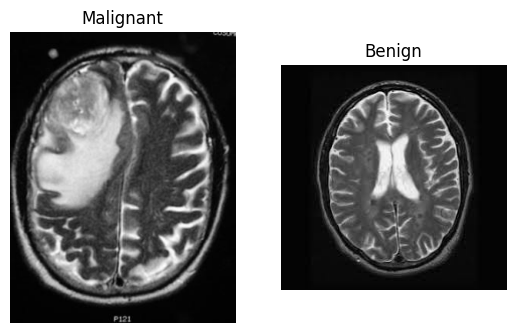

In [8]:
orig_img_malignant = cv2.imread("22_malignant.jpg", 0) # 1 indicates color image
orig_img_benign = cv2.imread("data/benign/21.jpg",0) # 1 indicates color image 

plt.subplot(1,2,1), plt.imshow(orig_img_malignant, cmap='gray')
plt.axis('off')
plt.title('Malignant')
plt.subplot(1,2,2), plt.imshow(orig_img_benign, cmap='gray')
plt.axis('off')
plt.title('Benign')
plt.axis('off')

### Median Filtering

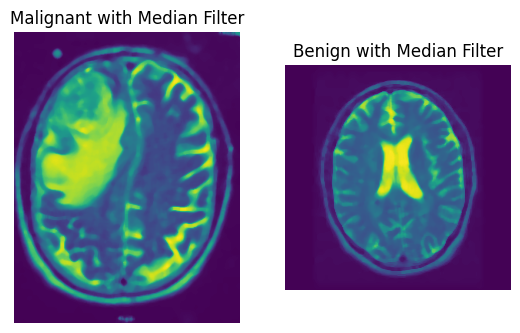

In [9]:
# remove noise or annotated images like the one with the arrow
# Using 5*5 kernel
median_filtered_malignant = cv2.medianBlur(orig_img_malignant, 7)
plt.subplot(1,2,1), plt.imshow(median_filtered_malignant)
plt.axis('off')
plt.title('Malignant with Median Filter')
median_filtered_benign = cv2.medianBlur(orig_img_benign, 5)
plt.subplot(1,2,2), plt.imshow(median_filtered_benign)
plt.axis('off')
plt.title('Benign with Median Filter')
plt.show()

### Edge Detection

<function matplotlib.pyplot.show(close=None, block=None)>

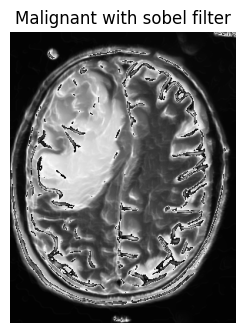

In [15]:
sobel_x= np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

sobel_img_x = cv2.filter2D(median_filtered_malignant, -1, sobel_x)
sobel_img_y = cv2.filter2D(median_filtered_malignant, -1, sobel_y)
sobel_img = sobel_img_x + sobel_img_y + median_filtered_malignant

plt.subplot(1,2,1), plt.imshow(sobel_img, cmap='gray')
plt.axis('off')
plt.title('Malignant with sobel filter')
plt.show

## Binary threshold refine binary mask

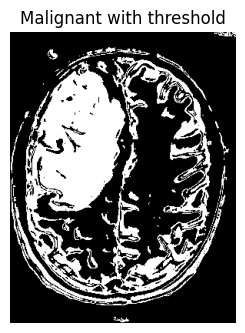

In [16]:
threshold = 125
maxValue = 255

# Threshold the pixel values
th_malignant, thresh_malignant = cv2.threshold(sobel_img, threshold, maxValue, cv2.THRESH_BINARY)
plt.subplot(1,2,1), plt.imshow(thresh_malignant,cmap='gray')
plt.axis('off')
plt.title('Malignant with threshold')
plt.show()

## Morphological operations
to determine the background and foreground of the image

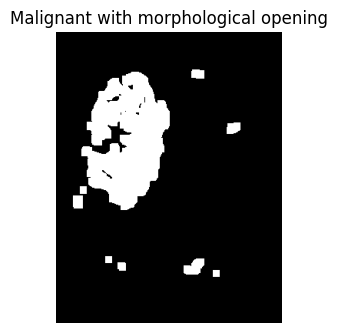

In [22]:
# Distinct the tumor from the background
kernel = np.ones((5,5),np.uint8) # tuning
opening_malignant = cv2.morphologyEx(thresh_malignant,cv2.MORPH_OPEN,kernel, iterations = 2)

plt.subplot(1,2,1), plt.imshow(opening_malignant,cmap='gray')
plt.axis('off')
plt.title('Malignant with morphological opening')
plt.show()

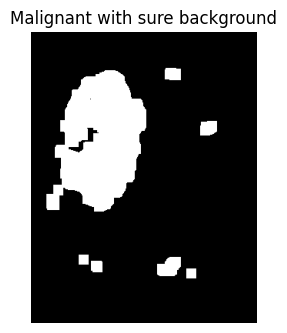

In [23]:
# to remove false positives via dilation
sure_bg_malignant = cv2.dilate(opening_malignant,kernel,iterations=1) # increasing the iterations will decrease the false positives but will also decrease the true positives

plt.subplot(1,2,1), plt.imshow(sure_bg_malignant,cmap='gray')
plt.axis('off')
plt.title('Malignant with sure background')
plt.show()

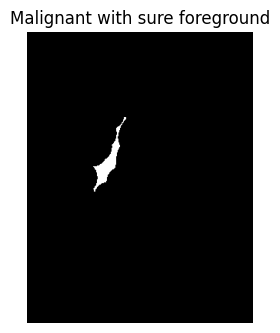

In [25]:
#  white region shows sure foreground area
dist_transform_malignant = cv2.distanceTransform(opening_malignant, cv2.DIST_L2, 5)
ret_malignant, sure_fg_malignant = cv2.threshold(dist_transform_malignant,0.7*dist_transform_malignant.max(),255,0)

plt.subplot(1,2,1), plt.imshow(sure_fg_malignant,cmap='gray')
plt.axis('off')
plt.title('Malignant with sure foreground')
plt.show()

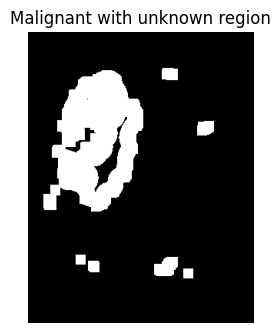

In [26]:
# Identifying regions where we don't know whether foreground and background
# Watershed algorithm
sure_fg_malignant = np.uint8(sure_fg_malignant) # Convert sure_fg to 8 bit because watershed takes 8 bit input
unknown_malignant = cv2.subtract(sure_bg_malignant,sure_fg_malignant)

plt.subplot(1,2,1), plt.imshow(unknown_malignant,cmap='gray')
plt.axis('off')
plt.title('Malignant with unknown region')
plt.show()

## Watershed Segmentation

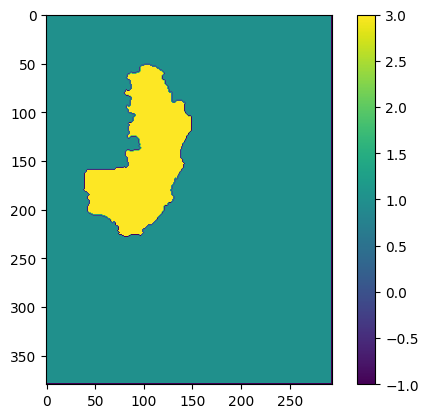

In [27]:
orig_img_malignant_col = cv2.imread("22_malignant.jpg", 1) # 1 indicates color image
orig_img_benign_col = cv2.imread("4_benign.jpg",1) # 1 indicates color image

contours, hierarchy = cv2.findContours(sure_fg_malignant,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

# Creating a numpy array for markers and converting the image to 32 bit using dtype paramter
marker = np.zeros((orig_img_malignant.shape[0], orig_img_malignant.shape[1]),dtype = np.int32)

marker = np.int32(sure_fg_malignant) + np.int32(sure_bg_malignant)

# Marker Labelling
for id in range(len(contours)):
    cv2.drawContours(marker,contours,id,id+2, -1)

marker = marker + 1

marker[unknown_malignant==255] = 0

copy_img = orig_img_malignant_col.copy()

cv2.watershed(copy_img, marker)

imgplt = plt.imshow(marker)
plt.colorbar()
plt.show()


In [28]:
# # Save the image to another folder
# if not os.path.exists('data/preprocessed_data'):
#     os.makedirs('data/malignant_segmented')


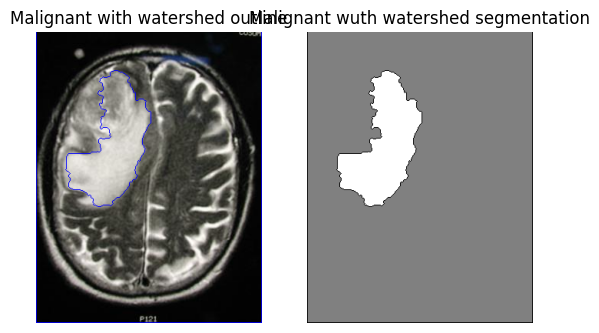

In [29]:
copy_img[marker==-1]=(0,0,255)
cv2.imwrite('img.jpg',copy_img)

plt.subplot(1,2,1), plt.imshow(copy_img,cmap='gray')
plt.axis('off')
plt.title('Malignant with watershed outline')
plt.subplot(1,2,2), plt.imshow(marker,cmap='gray')
plt.axis('off')
plt.title('Malignant wuth watershed segmentation')
plt.show()

brekdown with fine tuned parameters

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def watershed_segmentation(image_path, show_plot=False, show_res=False):
    original_image = cv2.imread(image_path, 1)
    grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    
    # median filter
    median_filtered_image = cv2.medianBlur(grayscale_image, 13)
    # median_filtered_image = cv2.medianBlur(grayscale_image, 9)
    # median_filtered_image = cv2.medianBlur(grayscale_image, 7)
    # median_filtered_image = cv2.medianBlur(grayscale_image, 3)
    
    # edge detect vertical and horizontal
    sobel_x_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y_kernel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    sobel_x_image = cv2.filter2D(median_filtered_image, -1, sobel_x_kernel)
    sobel_y_image = cv2.filter2D(median_filtered_image, -1, sobel_y_kernel)
    
    # unify sobel Images
    sobel_image = sobel_x_image + sobel_y_image + grayscale_image
    
    # thresholding
    threshold_value = 100 # experiment range (75, 200)
    max_value = 255
    _, thresholded_image = cv2.threshold(sobel_image, threshold_value, max_value, cv2.THRESH_BINARY)
    
    # morphological operations
    kernel = np.ones((5, 5), np.uint8) # experiment range (3, 9)
    opening = cv2.morphologyEx(thresholded_image, cv2.MORPH_OPEN, kernel, iterations=2)
    # opening = cv2.morphologyEx(thresholded_image, cv2.MORPH_OPEN, kernel, iterations=3)
    # opening = cv2.morphologyEx(thresholded_image, cv2.MORPH_OPEN, kernel, iterations=4)
    
    # sure Background Area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    
    # dist Transform
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    
    # find unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # marker labeling
    contours, hierarchy = cv2.findContours(sure_fg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    marker = np.zeros((original_image.shape[0], original_image.shape[1]), dtype=np.int32)
    marker = np.int32(sure_fg) + np.int32(sure_bg)
    
    # label marker
    for id in range(len(contours)):
        cv2.drawContours(marker, contours, id, id + 2, -1)
    
    marker = marker + 1
    marker[unknown == 255] = 0
    
    result_image = original_image.copy()
    cv2.watershed(result_image, marker)
    
    result_image[marker == -1] = (0, 0, 255)
    cv2.imwrite('segmented_image.jpg', result_image)

    if show_plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(result_image)
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(marker)
        plt.title('Segmented Image')
        plt.axis('off')
        plt.colorbar()
        plt.show()
        
    if show_res:
        return result_image, marker
    
    return None

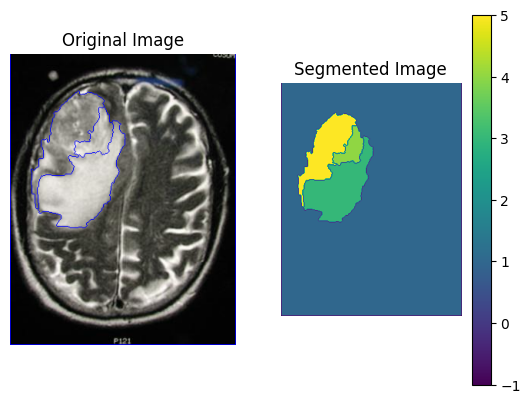

In [29]:
# print(watershed_segmentation('preprocessed/malignant/50.jpg', True, False))
watershed_segmentation('data/malignant/22.jpg', True, False)

['106.jpg', '107.jpg', '112.jpg', '113.jpg', '115.jpg', '116.jpg', '120.jpg', '157.jpg']


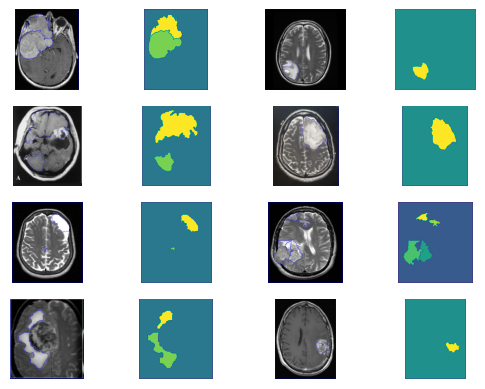

In [30]:
import os

# Define the directory containing the images
image_directory = 'data/malignant'

# Get a list of image files in the directory
image_files = os.listdir(image_directory)[:8]  # Get the first 8 images

# Apply the filter and store resulting images in a list
after_segmentation = []
file_names = []
for file in image_files:
    image_path = os.path.join(image_directory, file)
    copy_image, marker = watershed_segmentation(image_path, False, True)
    after_segmentation.append(copy_image)
    after_segmentation.append(marker)
    file_names.append(file)
    
for i in range(16):
    idx=f"44{i+1}"
    plt.subplot(4,4,i+1)
    plt.imshow(after_segmentation[i])
    plt.axis('off')
print(file_names)